# Data Preprocessing

In [9]:
from pydub import AudioSegment
df = pd.DataFrame(columns=['Sample', ' original_spk', ' gender', ' original_time', ' type_voc', ' start_voc', 'end_voc'])
file1 = open("vocalizationcorpus/labels.txt","r")
for aline in file1:
    values = aline.split(',')
    values[-1] = values[-1].strip("\n")
    df.loc[len(df)] = values[0:7]

In [25]:
for row in df.iterrows():    
    t1 = float(row[1][5]) * 1000
    t2 = float(row[1][6]) * 1000
    duration = t2 - t1
    newAudio = AudioSegment.from_wav("vocalizationcorpus/data/" + row[1][0] + ".wav")
    newAudio = newAudio[t1:t2]
    if row[1][4] == 'filler' and duration > 100:
        newAudio.export("Filler Words/" + row[1][0] + ".wav", format="wav")
    if row[1][4] == 'laughter' and duration > 100:
        newAudio.export("Laughter/" + row[1][0] + ".wav", format="wav")
    print(row[1][0], row[1][4], duration)

In [95]:
def partitionAudio(filename, name):
    newAudio = AudioSegment.from_wav(filename)
    t1 = 0
    t2 = 1000 * 1
    while t2 < len(newAudio):
        print(t2/1000)
        newAudio[t1:t2].export('Laughter/' + name + '-laugh-' + str(t2) + '.wav', format="wav")
        t1 += 1000 * 1
        t2 += 1000 * 1
#partitionAudio("Silence.wav")

import os

directory = os.fsencode("Laughter")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    print(filename)
    partitionAudio("Laughter/" + filename, filename)

J. Jonah Jameson Laughing.wav
1.0
2.0
3.0
4.0
laughter1.wav
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
laughter2.wav
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
laughter3.wav
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
laughter4.wav
1.0
2.0
3.0
S0002.wav
1.0
S0005.wav
S0006.wav
1.0
S0009.wav
1.0
2.0
S0010.wav
1.0
S0011.wav
1.0
S0012.wav
1.0
S0013.wav
1.0
S0015.wav
S0017.wav
S0021.wav
S0023.wav
S0024.wav
S0025.wav
S0026.wav
1.0
S0027.wav
S0031.wav
1.0
S0032.wav
S0033.wav
S0038.wav
S0046.wav
S0050.wav
1.0
S0052.wav
1.0
S0053.wav
S0059.wav
S0066.wav
1.0
S0067.wav
1.0
S0071.wav
1.0
2.0
S0087.wav
1.0
S0090.wav
S0098.wav
1.0
2.0
S0103.wav
S0104.wav
S0105.wav
S0108.wav
S0115.wav
S0124.wav
S0125.wav
S0126.wav
S0127.wav
1.0
2.0
S0129.wav
S0130.wav
S0132.wav
S0134.wav
S0135.wav
S0136.wav
1.0
S0137.wav
1.0
S0138.wav
S0140.wav
S0141.

S2429.wav
S2433.wav
S2434.wav
S2436.wav
1.0
S2437.wav
S2438.wav
S2439.wav
1.0
2.0
3.0
4.0
S2440.wav
S2441.wav
1.0
2.0
3.0
S2442.wav
1.0
2.0
S2446.wav
S2447.wav
1.0
2.0
S2448.wav
S2449.wav
S2451.wav
1.0
S2452.wav
S2457.wav
1.0
S2460.wav
S2463.wav
S2467.wav
S2469.wav
S2482.wav
S2485.wav
1.0
S2488.wav
S2493.wav
S2495.wav
1.0
S2498.wav
S2503.wav
1.0
S2504.wav
1.0
2.0
S2505.wav
1.0
2.0
3.0
4.0
S2506.wav
1.0
S2508.wav
S2513.wav
1.0
S2516.wav
1.0
S2524.wav
S2532.wav
1.0
S2535.wav
S2540.wav
1.0
S2542.wav
S2546.wav
S2557.wav
1.0
S2561.wav
S2562.wav
S2564.wav
S2568.wav
1.0
2.0
S2569.wav
S2572.wav
1.0
S2574.wav
1.0
S2577.wav
1.0
S2578.wav
1.0
S2582.wav
1.0
S2583.wav
S2584.wav
S2585.wav
1.0
S2586.wav
S2587.wav
S2593.wav
1.0
S2595.wav
S2601.wav
S2603.wav
1.0
S2604.wav
1.0
S2606.wav
1.0
S2608.wav
1.0
S2609.wav
1.0
S2610.wav
S2612.wav
S2613.wav
1.0
S2615.wav
1.0
2.0
S2617.wav
S2618.wav
S2625.wav
S2640.wav
1.0
S2643.wav
S2645.wav
S2647.wav
1.0
S2649.wav
S2651.wav
1.0
S2654.wav
S2665.wav
S2674.wav
1.0


# DeepCall

Step 1: Feature Extraction - after collection audio data, extract the features  
Step 2: Speaker Clustering - identify who is speaker 1 and who is speaker 2  
Step 3: Training - train your model to classify the data into: Speech, Laughter, Filler Words  
Step 4: User Study

In [89]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from pyAudioAnalysis import audioSegmentation
from pyAudioAnalysis import audioTrainTest as aT
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Classifies audio into 2 speakers + plot functionality
def speakerDiarization(filename, plot = False):
    speakers = audioSegmentation.speakerDiarization(filename, 2, plot_res=False)                                            
    dataframe=pd.DataFrame(speakers, columns=['category'])
    dataframe["seconds"] = np.linspace(0,dataframe.shape[0]/5,dataframe.shape[0])
    
    if plot == True:
        generatePlot(dataframe)
    return dataframe

# Plot functionality for speakerDiarization
def generatePlot(dataframe):
    figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.style.use('ggplot')
    x = dataframe["seconds"]
    plt.xticks(np.arange(min(x), max(x)+1, 5.0))
    plt.xticks(rotation=90)
    plt.yticks([0, 1])
    plt.xlabel("Seconds")
    plt.ylabel("Speakers")
    plt.title("Speaker Diarization")
    plt.plot(dataframe["seconds"], dataframe["category"])
    plt.show()

In [ ]:
[fs, x] = audioBasicIO.readAudioFile("Sinclair.wav")

In [ ]:
fs

In [ ]:
speakers = audioSegmentation.speakerDiarization("Sinclair.wav", 2, plot_res=False)                                            
dataframe=pd.DataFrame(speakers, columns=['category'])
dataframe["seconds"] = np.linspace(0,dataframe.shape[0]/5,dataframe.shape[0])
dataframe.head()

# Speaker Diarization 

This algorithm allows us to know who is speaking in a conversation.

In [ ]:
speakerDiarization("Sinclair.wav", plot = True)

# Machine Learning Classification!

We extract mid-term features. We use a long-term averaging of the mid-term features, leading to 1 feature vector for each class.

In [ ]:
aT.featureAndTrain(["Filler Words","Laughter", "Speech"], 0.1, 0.1, aT.shortTermWindow, aT.shortTermStep, "randomforest", "rf", perTrain=0.60)

In [ ]:
aT.featureAndTrain(["Filler Words","Laughter", "Speech"], 0.1, 0.1, aT.shortTermWindow, aT.shortTermStep, "gradientboosting", "gb",perTrain=0.60)

In [96]:
aT.featureAndTrain(["Filler Words","Laughter", "Speech", "Background"], 0.2, 0.2, aT.shortTermWindow, aT.shortTermStep, "svm_rbf", "svm",perTrain=0.60)

Analyzing file 1 of 1947: Filler Words\S0001.wav
Analyzing file 2 of 1947: Filler Words\S0003.wav
Analyzing file 3 of 1947: Filler Words\S0004.wav
Analyzing file 4 of 1947: Filler Words\S0007.wav
Analyzing file 5 of 1947: Filler Words\S0008.wav
Analyzing file 6 of 1947: Filler Words\S0018.wav
  (AUDIO FILE TOO SMALL - SKIPPING)
Analyzing file 7 of 1947: Filler Words\S0019.wav
Analyzing file 8 of 1947: Filler Words\S0020.wav
Analyzing file 9 of 1947: Filler Words\S0022.wav
Analyzing file 10 of 1947: Filler Words\S0028.wav
Analyzing file 11 of 1947: Filler Words\S0029.wav
Analyzing file 12 of 1947: Filler Words\S0030.wav
Analyzing file 13 of 1947: Filler Words\S0034.wav
Analyzing file 14 of 1947: Filler Words\S0035.wav
Analyzing file 15 of 1947: Filler Words\S0036.wav
Analyzing file 16 of 1947: Filler Words\S0037.wav
Analyzing file 17 of 1947: Filler Words\S0039.wav
Analyzing file 18 of 1947: Filler Words\S0040.wav
Analyzing file 19 of 1947: Filler Words\S0041.wav
Analyzing file 20 of 19

Analyzing file 168 of 1947: Filler Words\S0281.wav
Analyzing file 169 of 1947: Filler Words\S0282.wav
Analyzing file 170 of 1947: Filler Words\S0283.wav
Analyzing file 171 of 1947: Filler Words\S0284.wav
Analyzing file 172 of 1947: Filler Words\S0285.wav
Analyzing file 173 of 1947: Filler Words\S0286.wav
Analyzing file 174 of 1947: Filler Words\S0289.wav
  (AUDIO FILE TOO SMALL - SKIPPING)
Analyzing file 175 of 1947: Filler Words\S0290.wav
Analyzing file 176 of 1947: Filler Words\S0291.wav
Analyzing file 177 of 1947: Filler Words\S0293.wav
Analyzing file 178 of 1947: Filler Words\S0295.wav
Analyzing file 179 of 1947: Filler Words\S0297.wav
Analyzing file 180 of 1947: Filler Words\S0298.wav
Analyzing file 181 of 1947: Filler Words\S0299.wav
Analyzing file 182 of 1947: Filler Words\S0302.wav
Analyzing file 183 of 1947: Filler Words\S0303.wav
Analyzing file 184 of 1947: Filler Words\S0304.wav
Analyzing file 185 of 1947: Filler Words\S0305.wav
Analyzing file 186 of 1947: Filler Words\S0306

Analyzing file 336 of 1947: Filler Words\S0556.wav
Analyzing file 337 of 1947: Filler Words\S0557.wav
Analyzing file 338 of 1947: Filler Words\S0558.wav
Analyzing file 339 of 1947: Filler Words\S0559.wav
Analyzing file 340 of 1947: Filler Words\S0560.wav
Analyzing file 341 of 1947: Filler Words\S0562.wav
Analyzing file 342 of 1947: Filler Words\S0563.wav
Analyzing file 343 of 1947: Filler Words\S0564.wav
Analyzing file 344 of 1947: Filler Words\S0565.wav
Analyzing file 345 of 1947: Filler Words\S0566.wav
Analyzing file 346 of 1947: Filler Words\S0567.wav
Analyzing file 347 of 1947: Filler Words\S0568.wav
Analyzing file 348 of 1947: Filler Words\S0569.wav
Analyzing file 349 of 1947: Filler Words\S0570.wav
Analyzing file 350 of 1947: Filler Words\S0571.wav
Analyzing file 351 of 1947: Filler Words\S0572.wav
Analyzing file 352 of 1947: Filler Words\S0575.wav
Analyzing file 353 of 1947: Filler Words\S0576.wav
Analyzing file 354 of 1947: Filler Words\S0577.wav
Analyzing file 355 of 1947: Fil

Analyzing file 502 of 1947: Filler Words\S0776.wav
Analyzing file 503 of 1947: Filler Words\S0777.wav
Analyzing file 504 of 1947: Filler Words\S0778.wav
Analyzing file 505 of 1947: Filler Words\S0780.wav
Analyzing file 506 of 1947: Filler Words\S0781.wav
Analyzing file 507 of 1947: Filler Words\S0782.wav
Analyzing file 508 of 1947: Filler Words\S0783.wav
Analyzing file 509 of 1947: Filler Words\S0784.wav
  (AUDIO FILE TOO SMALL - SKIPPING)
Analyzing file 510 of 1947: Filler Words\S0785.wav
Analyzing file 511 of 1947: Filler Words\S0786.wav
Analyzing file 512 of 1947: Filler Words\S0787.wav
Analyzing file 513 of 1947: Filler Words\S0788.wav
Analyzing file 514 of 1947: Filler Words\S0789.wav
Analyzing file 515 of 1947: Filler Words\S0791.wav
Analyzing file 516 of 1947: Filler Words\S0793.wav
Analyzing file 517 of 1947: Filler Words\S0795.wav
Analyzing file 518 of 1947: Filler Words\S0796.wav
Analyzing file 519 of 1947: Filler Words\S0797.wav
Analyzing file 520 of 1947: Filler Words\S0798

Analyzing file 661 of 1947: Filler Words\S0969.wav
Analyzing file 662 of 1947: Filler Words\S0970.wav
Analyzing file 663 of 1947: Filler Words\S0971.wav
Analyzing file 664 of 1947: Filler Words\S0972.wav
Analyzing file 665 of 1947: Filler Words\S0977.wav
Analyzing file 666 of 1947: Filler Words\S0978.wav
Analyzing file 667 of 1947: Filler Words\S0983.wav
Analyzing file 668 of 1947: Filler Words\S0984.wav
Analyzing file 669 of 1947: Filler Words\S0988.wav
Analyzing file 670 of 1947: Filler Words\S0989.wav
Analyzing file 671 of 1947: Filler Words\S0991.wav
Analyzing file 672 of 1947: Filler Words\S0992.wav
Analyzing file 673 of 1947: Filler Words\S0993.wav
Analyzing file 674 of 1947: Filler Words\S0994.wav
Analyzing file 675 of 1947: Filler Words\S0996.wav
Analyzing file 676 of 1947: Filler Words\S0997.wav
Analyzing file 677 of 1947: Filler Words\S0998.wav
Analyzing file 678 of 1947: Filler Words\S0999.wav
Analyzing file 679 of 1947: Filler Words\S1000.wav
  (AUDIO FILE TOO SMALL - SKIPP

Analyzing file 820 of 1947: Filler Words\S1168.wav
Analyzing file 821 of 1947: Filler Words\S1170.wav
Analyzing file 822 of 1947: Filler Words\S1172.wav
Analyzing file 823 of 1947: Filler Words\S1173.wav
Analyzing file 824 of 1947: Filler Words\S1174.wav
Analyzing file 825 of 1947: Filler Words\S1175.wav
Analyzing file 826 of 1947: Filler Words\S1178.wav
Analyzing file 827 of 1947: Filler Words\S1179.wav
Analyzing file 828 of 1947: Filler Words\S1180.wav
Analyzing file 829 of 1947: Filler Words\S1181.wav
Analyzing file 830 of 1947: Filler Words\S1182.wav
Analyzing file 831 of 1947: Filler Words\S1183.wav
Analyzing file 832 of 1947: Filler Words\S1184.wav
Analyzing file 833 of 1947: Filler Words\S1185.wav
Analyzing file 834 of 1947: Filler Words\S1186.wav
Analyzing file 835 of 1947: Filler Words\S1187.wav
Analyzing file 836 of 1947: Filler Words\S1188.wav
Analyzing file 837 of 1947: Filler Words\S1189.wav
Analyzing file 838 of 1947: Filler Words\S1192.wav
Analyzing file 839 of 1947: Fil

Analyzing file 986 of 1947: Filler Words\S1407.wav
Analyzing file 987 of 1947: Filler Words\S1408.wav
Analyzing file 988 of 1947: Filler Words\S1409.wav
Analyzing file 989 of 1947: Filler Words\S1411.wav
Analyzing file 990 of 1947: Filler Words\S1412.wav
Analyzing file 991 of 1947: Filler Words\S1413.wav
  (AUDIO FILE TOO SMALL - SKIPPING)
Analyzing file 992 of 1947: Filler Words\S1414.wav
  (AUDIO FILE TOO SMALL - SKIPPING)
Analyzing file 993 of 1947: Filler Words\S1415.wav
Analyzing file 994 of 1947: Filler Words\S1417.wav
Analyzing file 995 of 1947: Filler Words\S1418.wav
Analyzing file 996 of 1947: Filler Words\S1420.wav
Analyzing file 997 of 1947: Filler Words\S1422.wav
Analyzing file 998 of 1947: Filler Words\S1423.wav
Analyzing file 999 of 1947: Filler Words\S1425.wav
Analyzing file 1000 of 1947: Filler Words\S1426.wav
Analyzing file 1001 of 1947: Filler Words\S1427.wav
Analyzing file 1002 of 1947: Filler Words\S1428.wav
Analyzing file 1003 of 1947: Filler Words\S1429.wav
Analyz

Analyzing file 1149 of 1947: Filler Words\S1639.wav
Analyzing file 1150 of 1947: Filler Words\S1640.wav
Analyzing file 1151 of 1947: Filler Words\S1641.wav
Analyzing file 1152 of 1947: Filler Words\S1642.wav
Analyzing file 1153 of 1947: Filler Words\S1643.wav
Analyzing file 1154 of 1947: Filler Words\S1644.wav
Analyzing file 1155 of 1947: Filler Words\S1645.wav
Analyzing file 1156 of 1947: Filler Words\S1646.wav
Analyzing file 1157 of 1947: Filler Words\S1647.wav
Analyzing file 1158 of 1947: Filler Words\S1648.wav
Analyzing file 1159 of 1947: Filler Words\S1650.wav
Analyzing file 1160 of 1947: Filler Words\S1651.wav
Analyzing file 1161 of 1947: Filler Words\S1652.wav
Analyzing file 1162 of 1947: Filler Words\S1653.wav
Analyzing file 1163 of 1947: Filler Words\S1654.wav
Analyzing file 1164 of 1947: Filler Words\S1655.wav
Analyzing file 1165 of 1947: Filler Words\S1656.wav
Analyzing file 1166 of 1947: Filler Words\S1657.wav
Analyzing file 1167 of 1947: Filler Words\S1658.wav
Analyzing fi

Analyzing file 1302 of 1947: Filler Words\S1843.wav
Analyzing file 1303 of 1947: Filler Words\S1844.wav
Analyzing file 1304 of 1947: Filler Words\S1845.wav
Analyzing file 1305 of 1947: Filler Words\S1846.wav
Analyzing file 1306 of 1947: Filler Words\S1847.wav
Analyzing file 1307 of 1947: Filler Words\S1848.wav
Analyzing file 1308 of 1947: Filler Words\S1849.wav
Analyzing file 1309 of 1947: Filler Words\S1850.wav
  (AUDIO FILE TOO SMALL - SKIPPING)
Analyzing file 1310 of 1947: Filler Words\S1851.wav
Analyzing file 1311 of 1947: Filler Words\S1852.wav
Analyzing file 1312 of 1947: Filler Words\S1853.wav
Analyzing file 1313 of 1947: Filler Words\S1854.wav
Analyzing file 1314 of 1947: Filler Words\S1855.wav
Analyzing file 1315 of 1947: Filler Words\S1856.wav
Analyzing file 1316 of 1947: Filler Words\S1858.wav
Analyzing file 1317 of 1947: Filler Words\S1859.wav
Analyzing file 1318 of 1947: Filler Words\S1860.wav
Analyzing file 1319 of 1947: Filler Words\S1861.wav
Analyzing file 1320 of 1947:

Analyzing file 1461 of 1947: Filler Words\S2041.wav
Analyzing file 1462 of 1947: Filler Words\S2042.wav
Analyzing file 1463 of 1947: Filler Words\S2043.wav
Analyzing file 1464 of 1947: Filler Words\S2044.wav
Analyzing file 1465 of 1947: Filler Words\S2046.wav
Analyzing file 1466 of 1947: Filler Words\S2047.wav
Analyzing file 1467 of 1947: Filler Words\S2048.wav
Analyzing file 1468 of 1947: Filler Words\S2050.wav
Analyzing file 1469 of 1947: Filler Words\S2052.wav
Analyzing file 1470 of 1947: Filler Words\S2053.wav
Analyzing file 1471 of 1947: Filler Words\S2054.wav
Analyzing file 1472 of 1947: Filler Words\S2056.wav
Analyzing file 1473 of 1947: Filler Words\S2058.wav
Analyzing file 1474 of 1947: Filler Words\S2060.wav
Analyzing file 1475 of 1947: Filler Words\S2061.wav
Analyzing file 1476 of 1947: Filler Words\S2062.wav
Analyzing file 1477 of 1947: Filler Words\S2063.wav
Analyzing file 1478 of 1947: Filler Words\S2064.wav
Analyzing file 1479 of 1947: Filler Words\S2065.wav
Analyzing fi

Analyzing file 1625 of 1947: Filler Words\S2246.wav
Analyzing file 1626 of 1947: Filler Words\S2247.wav
Analyzing file 1627 of 1947: Filler Words\S2248.wav
Analyzing file 1628 of 1947: Filler Words\S2249.wav
Analyzing file 1629 of 1947: Filler Words\S2250.wav
Analyzing file 1630 of 1947: Filler Words\S2255.wav
Analyzing file 1631 of 1947: Filler Words\S2257.wav
Analyzing file 1632 of 1947: Filler Words\S2260.wav
Analyzing file 1633 of 1947: Filler Words\S2261.wav
Analyzing file 1634 of 1947: Filler Words\S2262.wav
Analyzing file 1635 of 1947: Filler Words\S2267.wav
Analyzing file 1636 of 1947: Filler Words\S2269.wav
Analyzing file 1637 of 1947: Filler Words\S2270.wav
Analyzing file 1638 of 1947: Filler Words\S2275.wav
Analyzing file 1639 of 1947: Filler Words\S2276.wav
Analyzing file 1640 of 1947: Filler Words\S2277.wav
Analyzing file 1641 of 1947: Filler Words\S2279.wav
Analyzing file 1642 of 1947: Filler Words\S2281.wav
Analyzing file 1643 of 1947: Filler Words\S2283.wav
Analyzing fi

Analyzing file 1789 of 1947: Filler Words\S2533.wav
Analyzing file 1790 of 1947: Filler Words\S2534.wav
Analyzing file 1791 of 1947: Filler Words\S2536.wav
Analyzing file 1792 of 1947: Filler Words\S2537.wav
Analyzing file 1793 of 1947: Filler Words\S2538.wav
Analyzing file 1794 of 1947: Filler Words\S2539.wav
Analyzing file 1795 of 1947: Filler Words\S2541.wav
Analyzing file 1796 of 1947: Filler Words\S2543.wav
Analyzing file 1797 of 1947: Filler Words\S2544.wav
Analyzing file 1798 of 1947: Filler Words\S2545.wav
Analyzing file 1799 of 1947: Filler Words\S2547.wav
Analyzing file 1800 of 1947: Filler Words\S2548.wav
Analyzing file 1801 of 1947: Filler Words\S2549.wav
Analyzing file 1802 of 1947: Filler Words\S2550.wav
Analyzing file 1803 of 1947: Filler Words\S2551.wav
Analyzing file 1804 of 1947: Filler Words\S2552.wav
Analyzing file 1805 of 1947: Filler Words\S2553.wav
Analyzing file 1806 of 1947: Filler Words\S2554.wav
Analyzing file 1807 of 1947: Filler Words\S2555.wav
Analyzing fi

Analyzing file 1947 of 1947: Filler Words\filler2.wav
Feature extraction complexity ratio: 29.4 x realtime
Analyzing file 1 of 924: Laughter\J. Jonah Jameson Laughing.wav-laugh-1000.wav
Analyzing file 2 of 924: Laughter\J. Jonah Jameson Laughing.wav-laugh-2000.wav
Analyzing file 3 of 924: Laughter\J. Jonah Jameson Laughing.wav-laugh-3000.wav
Analyzing file 4 of 924: Laughter\J. Jonah Jameson Laughing.wav-laugh-4000.wav
Analyzing file 5 of 924: Laughter\S0002.wav
Analyzing file 6 of 924: Laughter\S0002.wav-laugh-1000.wav
Analyzing file 7 of 924: Laughter\S0005.wav
Analyzing file 8 of 924: Laughter\S0006.wav
Analyzing file 9 of 924: Laughter\S0006.wav-laugh-1000.wav
Analyzing file 10 of 924: Laughter\S0009.wav
Analyzing file 11 of 924: Laughter\S0009.wav-laugh-1000.wav
Analyzing file 12 of 924: Laughter\S0009.wav-laugh-2000.wav
Analyzing file 13 of 924: Laughter\S0010.wav
Analyzing file 14 of 924: Laughter\S0010.wav-laugh-1000.wav
Analyzing file 15 of 924: Laughter\S0011.wav
Analyzing fi

Analyzing file 178 of 924: Laughter\S0455.wav
Analyzing file 179 of 924: Laughter\S0456.wav-laugh-1000.wav
Analyzing file 180 of 924: Laughter\S0457.wav
Analyzing file 181 of 924: Laughter\S0458.wav
Analyzing file 182 of 924: Laughter\S0459.wav
Analyzing file 183 of 924: Laughter\S0460.wav
Analyzing file 184 of 924: Laughter\S0468.wav-laugh-1000.wav
Analyzing file 185 of 924: Laughter\S0469.wav
Analyzing file 186 of 924: Laughter\S0470.wav
Analyzing file 187 of 924: Laughter\S0470.wav-laugh-1000.wav
Analyzing file 188 of 924: Laughter\S0470.wav-laugh-2000.wav
Analyzing file 189 of 924: Laughter\S0472.wav
Analyzing file 190 of 924: Laughter\S0472.wav-laugh-1000.wav
Analyzing file 191 of 924: Laughter\S0472.wav-laugh-2000.wav
Analyzing file 192 of 924: Laughter\S0473.wav
Analyzing file 193 of 924: Laughter\S0480.wav
Analyzing file 194 of 924: Laughter\S0481.wav
Analyzing file 195 of 924: Laughter\S0484.wav
Analyzing file 196 of 924: Laughter\S0485.wav
Analyzing file 197 of 924: Laughter\

Analyzing file 349 of 924: Laughter\S1134.wav
Analyzing file 350 of 924: Laughter\S1135.wav
Analyzing file 351 of 924: Laughter\S1141.wav
Analyzing file 352 of 924: Laughter\S1145.wav
Analyzing file 353 of 924: Laughter\S1169.wav-laugh-1000.wav
Analyzing file 354 of 924: Laughter\S1169.wav-laugh-2000.wav
Analyzing file 355 of 924: Laughter\S1171.wav
Analyzing file 356 of 924: Laughter\S1176.wav
Analyzing file 357 of 924: Laughter\S1177.wav
Analyzing file 358 of 924: Laughter\S1190.wav
Analyzing file 359 of 924: Laughter\S1191.wav
Analyzing file 360 of 924: Laughter\S1198.wav
Analyzing file 361 of 924: Laughter\S1200.wav
Analyzing file 362 of 924: Laughter\S1202.wav
Analyzing file 363 of 924: Laughter\S1205.wav
Analyzing file 364 of 924: Laughter\S1205.wav-laugh-1000.wav
Analyzing file 365 of 924: Laughter\S1205.wav-laugh-2000.wav
Analyzing file 366 of 924: Laughter\S1207.wav
Analyzing file 367 of 924: Laughter\S1209.wav
Analyzing file 368 of 924: Laughter\S1210.wav
Analyzing file 369 o

Analyzing file 520 of 924: Laughter\S1662.wav
Analyzing file 521 of 924: Laughter\S1663.wav
Analyzing file 522 of 924: Laughter\S1667.wav
Analyzing file 523 of 924: Laughter\S1668.wav
Analyzing file 524 of 924: Laughter\S1670.wav
Analyzing file 525 of 924: Laughter\S1672.wav
Analyzing file 526 of 924: Laughter\S1673.wav
Analyzing file 527 of 924: Laughter\S1677.wav
Analyzing file 528 of 924: Laughter\S1678.wav
Analyzing file 529 of 924: Laughter\S1681.wav
Analyzing file 530 of 924: Laughter\S1682.wav
Analyzing file 531 of 924: Laughter\S1687.wav
Analyzing file 532 of 924: Laughter\S1688.wav
Analyzing file 533 of 924: Laughter\S1693.wav
Analyzing file 534 of 924: Laughter\S1699.wav
Analyzing file 535 of 924: Laughter\S1700.wav
Analyzing file 536 of 924: Laughter\S1712.wav
Analyzing file 537 of 924: Laughter\S1720.wav
Analyzing file 538 of 924: Laughter\S1722.wav
Analyzing file 539 of 924: Laughter\S1723.wav
Analyzing file 540 of 924: Laughter\S1726.wav
Analyzing file 541 of 924: Laughte

Analyzing file 695 of 924: Laughter\S2346.wav
Analyzing file 696 of 924: Laughter\S2347.wav
Analyzing file 697 of 924: Laughter\S2349.wav
Analyzing file 698 of 924: Laughter\S2352.wav
Analyzing file 699 of 924: Laughter\S2352.wav-laugh-1000.wav
Analyzing file 700 of 924: Laughter\S2352.wav-laugh-2000.wav
Analyzing file 701 of 924: Laughter\S2353.wav
Analyzing file 702 of 924: Laughter\S2356.wav
Analyzing file 703 of 924: Laughter\S2356.wav-laugh-1000.wav
Analyzing file 704 of 924: Laughter\S2356.wav-laugh-2000.wav
Analyzing file 705 of 924: Laughter\S2357.wav
Analyzing file 706 of 924: Laughter\S2358.wav
Analyzing file 707 of 924: Laughter\S2359.wav
Analyzing file 708 of 924: Laughter\S2360.wav
Analyzing file 709 of 924: Laughter\S2362.wav
Analyzing file 710 of 924: Laughter\S2363.wav
Analyzing file 711 of 924: Laughter\S2367.wav
Analyzing file 712 of 924: Laughter\S2368.wav
Analyzing file 713 of 924: Laughter\S2373.wav
Analyzing file 714 of 924: Laughter\S2379.wav
Analyzing file 715 o

Analyzing file 865 of 924: Laughter\laughter1.wav-laugh-1000.wav
Analyzing file 866 of 924: Laughter\laughter1.wav-laugh-10000.wav
Analyzing file 867 of 924: Laughter\laughter1.wav-laugh-11000.wav
Analyzing file 868 of 924: Laughter\laughter1.wav-laugh-12000.wav
Analyzing file 869 of 924: Laughter\laughter1.wav-laugh-13000.wav
Analyzing file 870 of 924: Laughter\laughter1.wav-laugh-14000.wav
Analyzing file 871 of 924: Laughter\laughter1.wav-laugh-16000.wav
Analyzing file 872 of 924: Laughter\laughter1.wav-laugh-17000.wav
Analyzing file 873 of 924: Laughter\laughter1.wav-laugh-18000.wav
Analyzing file 874 of 924: Laughter\laughter1.wav-laugh-19000.wav
Analyzing file 875 of 924: Laughter\laughter1.wav-laugh-2000.wav
Analyzing file 876 of 924: Laughter\laughter1.wav-laugh-3000.wav
Analyzing file 877 of 924: Laughter\laughter1.wav-laugh-4000.wav
Analyzing file 878 of 924: Laughter\laughter1.wav-laugh-5000.wav
Analyzing file 879 of 924: Laughter\laughter1.wav-laugh-6000.wav
Analyzing file 8

Analyzing file 75 of 138: Speech\Speech2.wav-Talk-4000.wav
Analyzing file 76 of 138: Speech\Speech2.wav-Talk-5000.wav
Analyzing file 77 of 138: Speech\Speech2.wav-Talk-6000.wav
Analyzing file 78 of 138: Speech\Speech2.wav-Talk-7000.wav
Analyzing file 79 of 138: Speech\Speech2.wav-Talk-8000.wav
Analyzing file 80 of 138: Speech\Speech2.wav-Talk-9000.wav
Analyzing file 81 of 138: Speech\Tekking1000.wav
Analyzing file 82 of 138: Speech\Tekking10000.wav
Analyzing file 83 of 138: Speech\Tekking11000.wav
Analyzing file 84 of 138: Speech\Tekking12000.wav
Analyzing file 85 of 138: Speech\Tekking13000.wav
Analyzing file 86 of 138: Speech\Tekking14000.wav
Analyzing file 87 of 138: Speech\Tekking15000.wav
Analyzing file 88 of 138: Speech\Tekking16000.wav
Analyzing file 89 of 138: Speech\Tekking17000.wav
Analyzing file 90 of 138: Speech\Tekking18000.wav
Analyzing file 91 of 138: Speech\Tekking19000.wav
Analyzing file 92 of 138: Speech\Tekking2000.wav
Analyzing file 93 of 138: Speech\Tekking20000.wa

Param = 5.00000 - classifier Evaluation Experiment 3 of 10
Param = 5.00000 - classifier Evaluation Experiment 4 of 10
Param = 5.00000 - classifier Evaluation Experiment 5 of 10
Param = 5.00000 - classifier Evaluation Experiment 6 of 10
Param = 5.00000 - classifier Evaluation Experiment 7 of 10
Param = 5.00000 - classifier Evaluation Experiment 8 of 10
Param = 5.00000 - classifier Evaluation Experiment 9 of 10
Param = 5.00000 - classifier Evaluation Experiment 10 of 10
Param = 10.00000 - classifier Evaluation Experiment 1 of 10
Param = 10.00000 - classifier Evaluation Experiment 2 of 10
Param = 10.00000 - classifier Evaluation Experiment 3 of 10
Param = 10.00000 - classifier Evaluation Experiment 4 of 10
Param = 10.00000 - classifier Evaluation Experiment 5 of 10
Param = 10.00000 - classifier Evaluation Experiment 6 of 10
Param = 10.00000 - classifier Evaluation Experiment 7 of 10
Param = 10.00000 - classifier Evaluation Experiment 8 of 10
Param = 10.00000 - classifier Evaluation Experi

# Uploading Trained Model

In [78]:
import pickle

file = open("svm",'rb')
svm = pickle.load(file)
print(svm.get_params())

{'C': 20.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


# Evaluating Speaker Classification

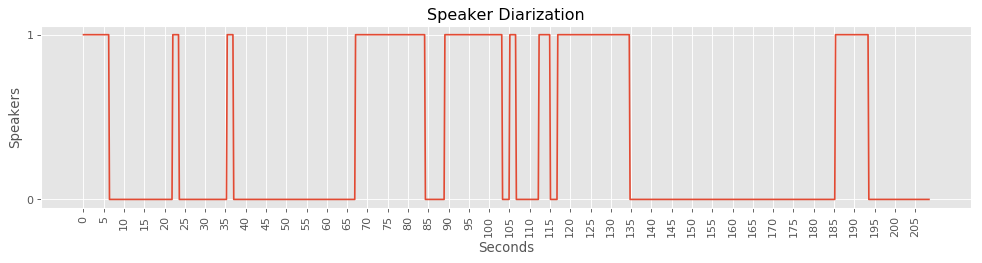

In [143]:
dataframe = speakerDiarization("Sinclair.wav", plot = True) 

In [144]:
dataframe["ground_Truth"] = 0

In [145]:
# Try to annotate who is speaking by the second.
df1 = dataframe[dataframe["seconds"].between(0, 7)]["ground_Truth"].replace(0, 1) # Speaker 1 is Joe Rogan
df2 = dataframe[dataframe["seconds"].between(7, 37)]["ground_Truth"] # Speaker 0 by default 
df3 = dataframe[dataframe["seconds"].between(37, 38)]["ground_Truth"].replace(0, 1)
df4 = dataframe[dataframe["seconds"].between(38, 67)]["ground_Truth"]
df5 = dataframe[dataframe["seconds"].between(67, 83)]["ground_Truth"].replace(0, 1)
df6 = dataframe[dataframe["seconds"].between(83, 88)]["ground_Truth"]
df7 = dataframe[dataframe["seconds"].between(88, 106)]["ground_Truth"].replace(0, 1)
df8 = dataframe[dataframe["seconds"].between(106, 113)]["ground_Truth"]
df9 = dataframe[dataframe["seconds"].between(113, 117)]["ground_Truth"].replace(0, 1)
df10 = dataframe[dataframe["seconds"].between(117, 118)]["ground_Truth"]
df11 = dataframe[dataframe["seconds"].between(118, 135)]["ground_Truth"].replace(0, 1)
df12 = dataframe[dataframe["seconds"].between(135, 185)]["ground_Truth"]
df13 = dataframe[dataframe["seconds"].between(185, 194)]["ground_Truth"].replace(0, 1)
df14 = dataframe[dataframe["seconds"].between(194, 209)]["ground_Truth"]

In [146]:
# Combine everything!
labels = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14])

In [147]:
# Add your annotations as a column
dataframe["ground_Truth"] = labels
dataframe

,category,seconds,ground_Truth
0,1.0,0.000000,1
1,1.0,0.200192,1
2,1.0,0.400384,1
3,1.0,0.600576,1
4,1.0,0.800768,1
5,1.0,1.000961,1
6,1.0,1.201153,1
7,1.0,1.401345,1
8,1.0,1.601537,1
9,1.0,1.801729,1


In [150]:
# Sklearn provides a quick way to check accuracy between ground truth and category.

from sklearn.metrics import accuracy_score
accuracy_score(list(dataframe["ground_Truth"]), list(dataframe["category"].astype(int)))

0.9318618042226487

In [94]:
def phoneAnalyzer(filename, df):
    [fs, x] = audioBasicIO.readAudioFile(filename)
    x = audioBasicIO.stereo2mono(x)
                             
    dataframe=pd.DataFrame(speakers, columns=['category'])
    dataframe["seconds"] = np.linspace(0,dataframe.shape[0]/5,dataframe.shape[0])

    windowSize = 1
    startWin = 0
    endWin = round(fs * windowSize)
    shift = round(fs * windowSize)
    timer = 0

    while endWin < len(x):
        windowSlice = x[startWin:endWin]
        mt_win = 0.2
        mt_step = 0.2
        st_win = aT.shortTermWindow # 0.05
        st_step = aT.shortTermStep # 0.05
        [classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step, compute_beat] = aT.load_model("svm")
        [mt_term_feats, st_features, _] = audioFeatureExtraction.mtFeatureExtraction(windowSlice, fs, round(mt_win * fs), round(mt_step * fs), round(fs * st_win), round(fs * st_step))
        mt_term_feats = mt_term_feats.mean(axis=1) 
        curFV = (mt_term_feats - MEAN) / STD
        R = classifier.predict(curFV.reshape(1,-1))[0]
        P = classifier.predict_proba(curFV.reshape(1,-1))[0]
        startWin += shift
        endWin += shift
        timer += windowSize
        speakerID = int(df[df["seconds"] > timer].iloc[0,0])
        print("Time (Seconds): ", timer, "Speaker: ", speakerID, "Classification: ", R, "Probability: ", round(max(P), 2))

phoneAnalyzer("toastmaster.wav", dataframe)

Time (Seconds):  1 Speaker:  1 Classification:  0.0 Probability:  0.84
Time (Seconds):  2 Speaker:  1 Classification:  2.0 Probability:  0.69
Time (Seconds):  3 Speaker:  1 Classification:  2.0 Probability:  0.85
Time (Seconds):  4 Speaker:  1 Classification:  2.0 Probability:  0.75
Time (Seconds):  5 Speaker:  1 Classification:  0.0 Probability:  0.72
Time (Seconds):  6 Speaker:  1 Classification:  0.0 Probability:  0.99
Time (Seconds):  7 Speaker:  1 Classification:  0.0 Probability:  0.71
Time (Seconds):  8 Speaker:  1 Classification:  0.0 Probability:  0.72
Time (Seconds):  9 Speaker:  1 Classification:  0.0 Probability:  0.85
Time (Seconds):  10 Speaker:  1 Classification:  0.0 Probability:  0.78
Time (Seconds):  11 Speaker:  1 Classification:  0.0 Probability:  0.73
Time (Seconds):  12 Speaker:  1 Classification:  0.0 Probability:  0.52
Time (Seconds):  13 Speaker:  1 Classification:  1.0 Probability:  0.51
Time (Seconds):  14 Speaker:  1 Classification:  0.0 Probability:  0.67
T